#   Tarea 2 pregunta 1


##  Importacion de bibliotecas

In [1]:
import os
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
import pathlib
import random
import string
import re
import numpy as np

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings
import tensorflow as tf
from tensorflow import keras    
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

##  Extraccion de datos y tratamiento

In [2]:
text_file_path="spa.txt"
with open(text_file_path) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

In [3]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]


In [4]:
# Limpiar texto
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size      = 15_000
sequence_length = 20
batch_size      = 64

def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# Vectorizar
eng_vectorization = TextVectorization(
    max_tokens  = vocab_size,
    output_mode = "int",
    output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

In [5]:
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return (
        {
            "english": eng,
            "spanish": spa[:, :-1],
        },
        spa[:, 1:],
    )

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)

train_ds = make_dataset(train_pairs)
val_ds   = make_dataset(val_pairs)

In [6]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["english"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["spanish"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


##  Hiperparametros

In [7]:
embed_dim = 256 
dense_dim = 1024
num_heads = 16 

##  Modelo

In [8]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(  input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)  
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
    
    def call(self,inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions 
    
    def compute_mask(self, inputs, mask=None):   
        return tf.math.not_equal(inputs, 0)

    def get_config(self):   
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,})  
        return config

In [9]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim          
        self.dense_dim = dense_dim        
        self.num_heads = num_heads        
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"),
                                            layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):   
        if mask is not None:                 
            mask = mask[:, tf.newaxis, :]    
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input  = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    
    def get_config(self):   
        config = super().get_config()
        config.update({
        "embed_dim": self.embed_dim,
        "num_heads": self.num_heads,
        "dense_dim": self.dense_dim,
        })
        return config

In [10]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential( [layers.Dense(dense_dim, activation="relu"),
                                             layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True 
    def get_config(self):
        config = super().get_config()
        config.update({
        "embed_dim": self.embed_dim,
        "num_heads": self.num_heads,
        "dense_dim": self.dense_dim,
        })
        return config
    
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")  
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))    
        mult = tf.concat(         
            [tf.expand_dims(batch_size, -1),              
            tf.constant([1, 1], dtype=tf.int32)], axis=0)         
        return tf.tile(mask, mult)
    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs) 
        if mask is not None:   
            padding_mask = tf.cast(   
                mask[:, tf.newaxis, :], dtype="int32")   
            padding_mask = tf.minimum(padding_mask, causal_mask)  
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask) 
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,   
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

In [11]:
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x) 

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs) 
x = layers.Dropout(0.3)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)  

transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [12]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

In [13]:
transformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 english (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3845120     ['english[0][0]']                
 alEmbedding)                                                                                     
                                                                                                  
 spanish (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   4733440     ['positional_embedding[0][0]'

##  Testing

In [14]:
EPOCAS = 3
history=transformer.fit(train_ds, epochs=EPOCAS, validation_data=val_ds)

Epoch 1/3
1302/1302 [==============================] - 251s 188ms/step - loss: 1.9386 - accuracy: 0.3026 - val_loss: 1.7036 - val_accuracy: 0.3436
Epoch 2/3
1302/1302 [==============================] - 243s 187ms/step - loss: 1.7307 - accuracy: 0.3600 - val_loss: 1.5947 - val_accuracy: 0.3794
Epoch 3/3
1302/1302 [==============================] - 243s 187ms/step - loss: 1.6437 - accuracy: 0.3855 - val_loss: 1.5432 - val_accuracy: 0.3947


In [15]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence         = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer(
            {
                "english": tokenized_input_sentence,
                "spanish": tokenized_target_sentence,
            }
        )

        #sampled_token_index = tf.convert_to_numpy(tf.argmax(predictions[0, i, :])).item(0)
        sampled_token_index = tf.argmax(predictions[0, i, :]).numpy().item(0)
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [16]:
test_eng_texts = [pair[0] for pair in test_pairs]
test_spa_texts = [pair[1] for pair in test_pairs]  # Aquí están las frases en español de referencia

# almacenar un diccionario de predicciones
predictions_dict = {}
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated     = decode_sequence(input_sentence)
    predictions_dict[input_sentence] = translated

In [17]:
predictions_dict


{"I think I've never seen you so drunk before.": '[start] no puedo ir a casa [end]',
 'This is a valid point of view.': '[start] Él es un buen problema [end]',
 'Do it by yourself.': '[start] no te gusta [end]',
 "He usually goes to McDonald's.": '[start] Él es un hombre más [end]',
 'You know where I work.': '[start] no te gusta nada [end]',
 'The baby fell asleep.': '[start] mi padre está en casa [end]',
 "We're serious.": '[start] no hay nada [end]',
 'Let him enter.': '[start] eso es lo que él es [end]',
 'Nobody believes what I say.': '[start] no puedo ir [end]',
 'I will go abroad next year.': '[start] me gustaría ir a la cama [end]',
 'Tom looks nervous.': '[start] tom es un [UNK] [end]',
 'Call security!': '[start] no hay nada [end]',
 'What is your occupation?': '[start] no puedo ir a casa [end]',
 'We want Tom.': '[start] no puedo ir [end]',
 'Take this medicine every six hours.': '[start] Él es un buen problema [end]',
 'Do you want me to call a doctor?': '[start] ellos se [

##  Extracción datos del otro set de datos

In [18]:
text_file_path2="eng-sentences.txt"
with open(text_file_path2) as f:
    lines = f.read().split("\n")[:-1]
text_pairs2 = []

for line in lines:
    eng = line.split("\t")
    text_pairs2.append((eng))
eng_sentences = [line.split("\t")[0] for line in lines]
new_eng_vectorized = eng_vectorization(eng_sentences)

In [19]:
predictions_dict2 = {}
for _ in range(len(new_eng_vectorized)):
    input_sentence = random.choice(test_eng_texts)
    translated     = decode_sequence(input_sentence)
    predictions_dict2[input_sentence] = translated

In [20]:
predictions_dict2

{'I want to be on this team.': '[start] no puedo ir a casa [end]',
 'The other children laughed.': '[start] la puerta se está en casa [end]',
 'Tom is a redneck.': '[start] tom es un hombre [end]',
 'Suddenly, it began to rain.': '[start] la puerta se ha estado en la cama [end]',
 "I hope you're happy.": '[start] no puedo ir a boston [end]',
 "I'm starving!": '[start] no puedo ir [end]',
 'Could you spell your name, please?': '[start] ellos se [UNK] de la ventana [end]',
 "I'm not angry.": '[start] no puedo ir [end]',
 'Are you kids hungry?': '[start] no hay nada que [end]',
 'Tom kicked the ball.': '[start] tom se está en casa [end]',
 'When are you going to get dinner ready?': '[start] no hay nada que hacer [end]',
 "Tom doesn't think Mary would be willing to lend him her guitar.": '[start] tom no tiene nada que mary se había estado en la cama [end]',
 'I firmly believe that your time will come.': '[start] no puedo ir a casa a la que me gusta [end]',
 'All three of these are mine.': 

##  Graficos

In [ ]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Suavizado para BLEU
smoothie = SmoothingFunction().method1

# Listas para almacenar resultados
bleu_scores = []
coincidencias = []
oraciones_idx = []

# Nota: test_eng_texts son las frases en inglés
# test_spa_texts son las frases de referencia en español
# predictions_dict contiene las traducciones predichas por la red

# Creamos las listas finales de referencias y predicciones
# (para que estén alineadas y tengan la misma longitud)
references = []
predictions = []

for idx, input_sentence in enumerate(test_eng_texts):
    # Checamos si la oración en inglés tiene traducción en predictions_dict
    if input_sentence in predictions_dict:
        pred_translation = predictions_dict[input_sentence].split()  # Convertimos en lista de palabras
        ref_translation  = test_spa_texts[idx].split()              # Convertimos en lista de palabras

        predictions.append(pred_translation)
        references.append(ref_translation)

        # Calculamos el BLEU
        bleu = sentence_bleu([ref_translation], pred_translation, weights=(1, 0, 0, 0), smoothing_function=smoothie)
        bleu_scores.append(bleu)

        # Coincidencias palabra a palabra
        coincidencias_palabras = sum(1 for r, p in zip(ref_translation, pred_translation) if r == p)
        coincidencias.append(coincidencias_palabras)
        oraciones_idx.append(idx + 1)  # Para graficar en el eje x

        # Imprimimos la comparación
        print(f"Oración {idx + 1}:")
        print("Inglés :", input_sentence)
        print("Ref    :", " ".join(ref_translation))
        print("Pred   :", " ".join(pred_translation))
        print(f"Coincidencias: {coincidencias_palabras}/{len(ref_translation)}\n")

# BLEU promedio
average_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
print("Promedio BLEU-1:", average_bleu)


Oración 105:
Inglés : I will go abroad next year.
Ref    : [start] El próximo año iré al extranjero. [end]
Pred   : [start] me gustaría ir a la cama [end]
Coincidencias: 2/8

Oración 1219:
Inglés : Tell them to come here.
Ref    : [start] Diles que vengan aquí. [end]
Pred   : [start] no hay nada que hacer [end]
Coincidencias: 1/6

Oración 3122:
Inglés : Tom looks nervous.
Ref    : [start] Tomás parece nervioso. [end]
Pred   : [start] tom es un [UNK] [end]
Coincidencias: 1/5

Oración 3435:
Inglés : We're serious.
Ref    : [start] Somos serios. [end]
Pred   : [start] no hay nada [end]
Coincidencias: 1/4

Oración 4854:
Inglés : I think I've never seen you so drunk before.
Ref    : [start] Creo que hasta ahora nunca te había visto tan borracho. [end]
Pred   : [start] no puedo ir a casa [end]
Coincidencias: 1/12

Oración 5016:
Inglés : It's deer season.
Ref    : [start] Es temporada de venados. [end]
Pred   : [start] ella es un hombre [end]
Coincidencias: 2/6

Oración 5339:
Inglés : Take th

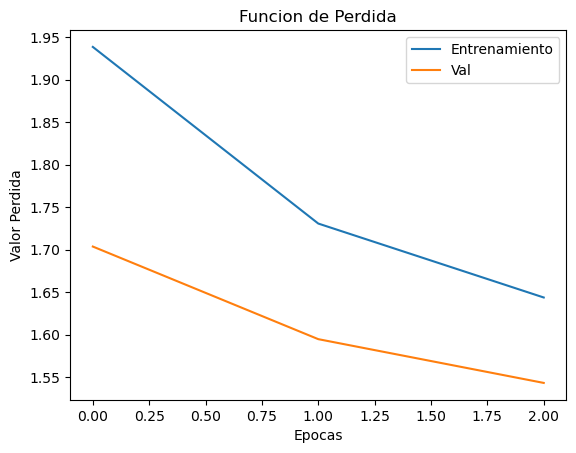

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Funcion de Perdida')
plt.ylabel('Valor Perdida')
plt.xlabel('Epocas')
plt.legend(['Entrenamiento', 'Val'], loc='best')
plt.savefig('funcion_perdida_modelo.png')

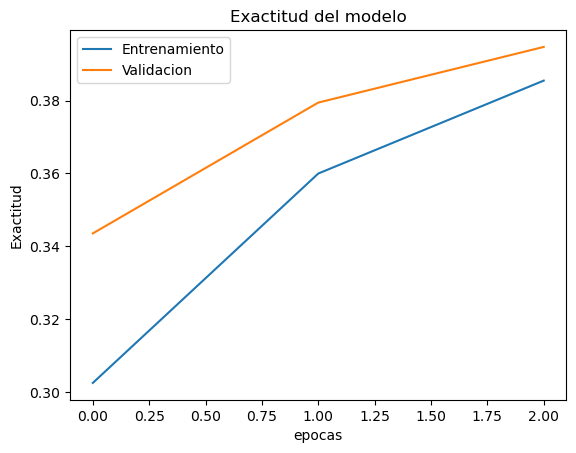

In [ ]:
# Guardar exactitud
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud')
plt.xlabel('epocas')
plt.legend(['Entrenamiento', 'Validacion'], loc='best')
plt.savefig('funcion_exactitudmodelo.png')